<a href="https://colab.research.google.com/github/alok13/Machine-Learning/blob/master/Male_Female.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt


In [4]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

***flow_from_directory*** method from ImageDataGenerator gets its label from Directory structure unlike normal somealgo.fit() where we have to provide the labels.
https://medium.com/difference-engine-ai/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2

In [6]:
! git clone https://github.com/alok13/ML_DataSets.git

Cloning into 'ML_DataSets'...
remote: Enumerating objects: 3308, done.
remote: Total 3308 (delta 0), reused 0 (delta 0), pack-reused 3308
Receiving objects: 100% (3308/3308), 596.78 MiB | 50.71 MiB/s, done.
Checking out files: 100% (3330/3330), done.


In [7]:
women=os.listdir("ML_DataSets/data/women")
women_len=len(women)
print(women_len)
men=os.listdir("ML_DataSets/data/men")
men_len=len(men)
print(men_len)

1912
1418


In [8]:
train_men_size=int(round(men_len*0.8))
train_women_size=int(round(women_len*0.8))
print(train_men_size)

1134


In [10]:
classes =["men","women"]
for cl in classes:
  img_path = os.path.join("ML_DataSets/data", cl)
  images = glob.glob(img_path+"/*" )
  print("{}: {} Images".format(cl, len(images)))

men: 1418 Images
women: 1912 Images


In [11]:
base_dir="ML_DataSets/data"
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

men: 1418 Images
women: 1912 Images


In [0]:
batch_size = 100
IMG_SHAPE = 150 
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [13]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2648 images belonging to 2 classes.


In [30]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 661 images belonging to 2 classes.


In [0]:

model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
from keras.callbacks import ModelCheckpoint
filepath="weights-improvement-trial_3-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

**Trail 1** With 80 epochs it took almost 3 hours to complete training with end accuracy being around 76% . Also in between it reached till 78% too.

**Trial 2** : added drop out at each layer. and changed the last unit of Dense layer to 2, since we only have 2 labels.Added callbacks and highest accuracy was 76%.

**Trail 3** : Added batch normalisation in each layer. It reached to max accuracy of 75% percent. And the graph shows quite a lot of underfitting.

In [38]:
epochs = 50

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))),
    callbacks=callbacks_list
)

Epoch 1/50
26/27 [===========================>..] - ETA: 5s - loss: 1.3055 - accuracy: 0.5691 
Epoch 00001: val_accuracy improved from -inf to 0.57640, saving model to weights-improvement-trial_3-01-0.58.hdf5
27/27 [==============================] - 174s 6s/step - loss: 1.2982 - accuracy: 0.5661 - val_loss: 1.2059 - val_accuracy: 0.5764
Epoch 2/50
26/27 [===========================>..] - ETA: 5s - loss: 0.8603 - accuracy: 0.5903 
Epoch 00002: val_accuracy did not improve from 0.57640
27/27 [==============================] - 163s 6s/step - loss: 0.8640 - accuracy: 0.5861 - val_loss: 2.6887 - val_accuracy: 0.5764
Epoch 3/50
26/27 [===========================>..] - ETA: 5s - loss: 0.8238 - accuracy: 0.5965 
Epoch 00003: val_accuracy did not improve from 0.57640
27/27 [==============================] - 161s 6s/step - loss: 0.8177 - accuracy: 0.5989 - val_loss: 4.1001 - val_accuracy: 0.5764
Epoch 4/50
26/27 [===========================>..] - ETA: 4s - loss: 0.7393 - accuracy: 0.5997
Epoch 0

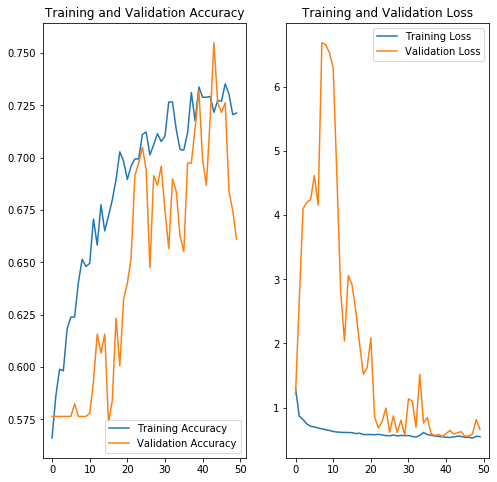

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()